# *svoboda lab / tactile navigation*

## Setup evnironment

In [1]:
import os
import glob
import sys
import requests
import numpy as np
import pandas as pd
import scipy.io as sio
import json
import re
from scipy.stats import f_oneway
from scipy.interpolate import UnivariateSpline
from helper.plots import *
save = True

##### Setup thunder

In [2]:
from thunder import ThunderContext
from thunder import Registration
from thunder import Series
from thunder import LinearRegression
from thunder import TuningModel
from thunder import Source, SourceModel
from thunder.extraction import BasicCleaner
from thunder import Colorize
image = Colorize.image

In [3]:
tsc = ThunderContext.start()

## Setup plotting

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

## Load raw data

In [5]:
path = 'https://s3.amazonaws.com/neuro.datasets/svoboda.lab/tactile.coding/'
s3path = 's3://neuro.datasets/svoboda.lab/tactile.coding/'

In [6]:
iSession = 13
session = '%02g' % iSession

#### Load info

In [7]:
r = requests.get(path + session + '/info.json').content
info = json.loads(r)
info['contributors'] = ', '.join(info['contributors'])
info['dimensions'] = str(info['dimensions'])
info = pd.DataFrame(info, index = [str(info['id'])])

#### Load params

In [8]:
covariates = pd.DataFrame.from_csv(path + session + '/params/covariates.csv')

Summarize trial information

In [9]:
trialData = covariates[['trialType','trialNum']].groupby(['trialNum'], sort=True).first()
trialData = trialData.join(covariates[['speed','trialNum','corPos']].groupby(['trialNum'], sort=True).mean())
trialData.sort('trialType', inplace = True, ascending = False)

In [10]:
speedThresh = 3

####Load images

In [11]:
refConf = tsc.loadJSON(s3path + session + '/reference/conf.json')
refConf['dims']
if len(refConf['dims']) == 3:
    nplanes = refConf['dims'][2]
else:
    nplanes = 1

In [12]:
path = s3path + session + '/images'
images = tsc.loadImages(path, inputFormat='tif', nplanes=nplanes, renumber=True, startIdx=0, stopIdx=1)
images.cache()
images.count();

## Perform image registration

Load reference

In [13]:
ref = tsc.loadImages(s3path + session + '/reference')

Do registration

In [14]:
reg = Registration('planarcrosscorr')
reg.prepare(ref[0])
model = reg.fit(images)
trans = model.toArray()

Plot registration results

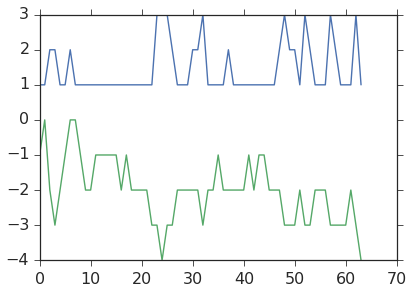

In [15]:
if nplanes > 1:
    plt.plot(trans[:,0,0]);
    plt.plot(trans[:,0,1]);
else:
    plt.plot(trans[:,0,0]);
    plt.plot(trans[:,0,1]);

Shift data and take mean

In [16]:
images = model.transform(images)
mean = images.mean()

## Extract source timeseries

Load sources

In [17]:
sources = tsc.loadSources(s3path + session + '/sources/sources.json')

Generate source timeseries

In [18]:
tsRoiRaw = sources.transform(images, collect = False)

Calculate neuropil signal by first generating source outline

In [19]:
outline = []
for iplane in range(1,4):
    index = np.where([x[2] == iplane for x in sources.centers])[0]
    sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
    sourcesPlane = sourcesPlane.outline(2,5).crop([0,0],[512,512])
    new = [[l+[iplane] for l in x] for x in sourcesPlane.coordinates]
    outline = outline + new
sourcesOutline = SourceModel(outline)

In [20]:
tsRoiOutlineRaw = sourcesOutline.transform(images, collect = False)

Convert to dff space and perform neuropil subtraction

Normalize and convert to table

In [21]:
tsRoi = tsRoiRaw.toTimeSeries()
tsRoi = tsRoi.normalize('window-fast',1260)
timeseriesRaw = pd.DataFrame(np.array(tsRoi.values().collect()))
timeseriesRaw.index.name = 'sourceId'

In [22]:
tsRoiNeuropil = tsRoiOutlineRaw.toTimeSeries()
tsRoiNeuropil = tsRoiNeuropil.normalize('window-fast',1260)
timeseriesNeuropil = pd.DataFrame(np.array(tsRoiNeuropil.values().collect()))
timeseriesNeuropil.index.name = 'sourceId'

In [23]:
timeseries = timeseriesRaw - timeseriesNeuropil

## Show sources

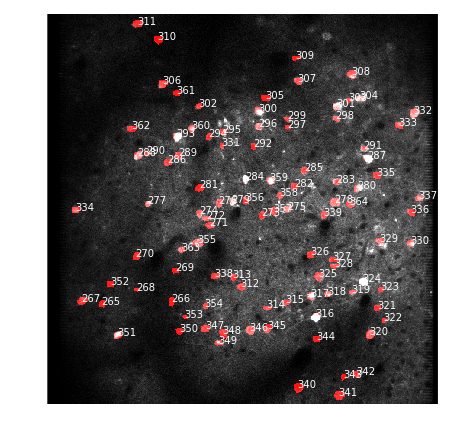

In [24]:
index = np.where([x[2] == iplane for x in sources.centers])[0]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', base=mean[:,:,iplane].clip(0,500))
image(img)
for s in range(sourcesPlane.count):
    plt.annotate(s=str(index[s]), xy=sourcesPlane[s].center[[1,0]], color='w');

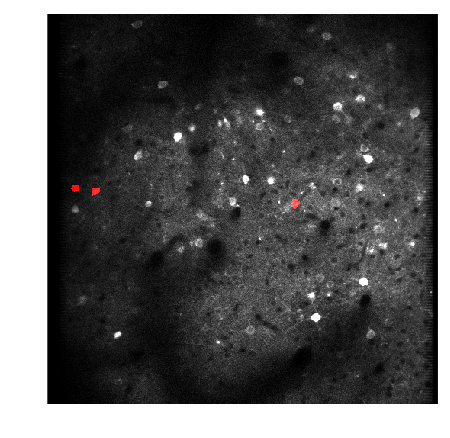

In [25]:
index = [160, 150, 159]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', outline=False, base=mean[:,:,iplane].clip(0,500))
image(img)